In [2]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas_profiling

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
df = pd.read_csv("src/data/data.csv", skip_blank_lines=True)
print(df.shape)

(289841, 23)


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Dropping all the column wherein the medical services information isn't available.
df = df[df.P_ISEV != 'U']

#Splitting test and train data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'P_ISEV') , 
                                                    df['P_ISEV'], 
                                                    test_size=0.2, 
                                                    random_state=100)

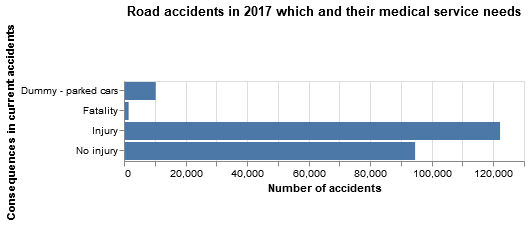

In [8]:
ncdb = pd.concat([X_train, y_train], axis = 1)

medical_encoding = {'1' : 'No injury',
                    '2' : 'Injury',
                    '3' : 'Fatality',
                    'N' : 'Dummy - parked cars',
                    'U' : 'Runaway cars',
                    'X' : 'Jurisdiction does not provide data'}
                    
ncdb['P_ISEV_tr'] = ncdb['P_ISEV'].map(medical_encoding)

med_service = list(ncdb['P_ISEV_tr'].unique())
med_service

q_0 = ncdb.groupby('P_ISEV_tr').agg({'C_CASE' : 'count'}).reset_index()

alt.Chart(q_0).mark_bar().encode(
    alt.Y('P_ISEV_tr:O', 
          title = "Consequences in current accidents"),
    alt.X('C_CASE:Q', 
          title = "Number of accidents")     
         ).properties(title = "Road accidents in 2017 which and their medical service needs")

**Predictive question**

Given the features( weather, time of the day, road surface, etc.) determine if emergency services would be needed for an accident.

**Inferential question**

Is the injury rate of sitting on the front row passenger seat different from sitting on the second row left seat?

In [9]:
stack = pd.concat([X_train, y_train], axis=1)

# subsetting columns of interest
needed_col = stack[['P_PSN', 'P_ISEV', 'V_TYPE', 'C_CASE', 'V_ID']]

# filtering column values
filter_PSN = needed_col.loc[needed_col['P_PSN'].isin(['13', '21'])]
filter_V_TYPE = filter_PSN.loc[filter_PSN['V_TYPE'] == '01']
filtered = filter_V_TYPE.loc[filter_V_TYPE['P_ISEV'].isin(['1','2'])]
dat = filtered.apply(pd.to_numeric)

# grouping variable into new categories
dat['row_num'] = np.where(dat.P_PSN > 20, 'behind driver', 'passenger seat')
dat['injury_class'] = np.where(dat.P_ISEV > 1, 'injury', 'Non-injury')

final_df = dat[dat.duplicated(subset=['C_CASE', 'V_ID'], keep = False)]
# remove error cases
check = final_df.groupby(['C_CASE','V_ID', 'row_num']).size().reset_index(name='counts')
check2 = check[check['counts']== 1]

final = final_df[(final_df['C_CASE'].isin(check2['C_CASE']) & final_df['V_ID'].isin(check2['V_ID']))]

pandas_profiling.ProfileReport(final[['row_num', 'injury_class']])
